# An example how to load and reproduce DBQA boosting

python3 compiling.py --backend numpy --path with_params/10q7l/sgd_10q_7l_42/

In [1]:
from boostvqe.utils import *
nqubits=10
nlayers=7
seed=42
target_epoch=2000
mode_dbr=DoubleBracketRotationType.group_commutator_third_order_reduced





[Qibo 0.2.9|INFO|2024-06-25 17:45:57]: Using numpy backend on /CPU:0


In [2]:
path = f"../with_params/{nqubits}q{nlayers}l/sgd_{nqubits}q_{nlayers}l_{seed}/"

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
circuit = build_circuit(nqubits, config["nlayers"])
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

vqe = VQE(circuit, hamiltonian)
# set target parameters into the VQE
vqe.circuit.set_parameters(params)

eo_xxz = XXZ_EvolutionOracle(nqubits, steps=1, order=2)
# implement the rotate by VQE on the level of circuits
fsoe = VQERotatedEvolutionOracle(eo_xxz, vqe)
# init gci with the vqe-rotated hamiltonian
gci = VQEBoostingGroupCommutatorIteration(
    input_hamiltonian_evolution_oracle=fsoe, mode_double_bracket_rotation=mode_dbr
)


Expecting energy -14.983620015119877 have -15.027786293128944 and           will get -15.051422491018238
Expecting energy -15.026332002054819 have -15.052510906021784 and           will get -15.065140277273663
After final loading step have energy  -15.068544151910661 


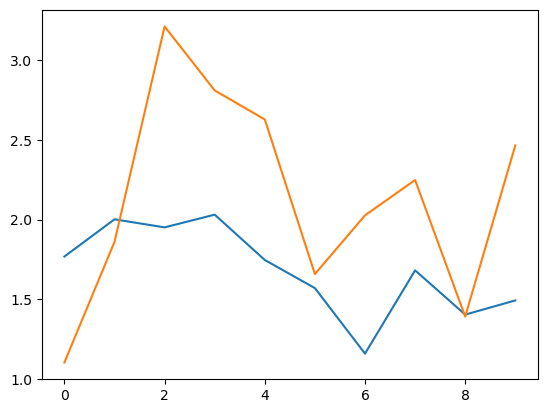

In [5]:
# upload system configuration and parameters for all the training
with open(path + "boosting_data.json") as file:
    boosting_results = json.load(file)

for key in boosting_results.keys():
    gci_step_data = boosting_results[key]
    plt.plot(gci_step_data['eo_d_params'])
    s = gci_step_data['mimizer_s']
    eo_d_name = gci_step_data['eo_d_name']
    if eo_d_name == "B Field":
        n_local = 1
    elif eo_d_name == "H_ClassicalIsing(B,J)":
        n_local = 2
    eo_d = get_gd_evolution_oracle(n_local, gci_step_data['eo_d_params'])
    loss_test = gci.loss( s, eo_d, mode_dbr = DoubleBracketRotationType.group_commutator)
    print(f"Expecting energy {gci_step_data['gci_loss']} have {gci.loss()} and\
           will get {loss_test}")
    gci( s, eo_d )
print(f"After final loading step have energy  {gci.loss()} ")
